In [1]:
# Import packages
import numpy as np
import pandas as pd
import pymysql as mysql
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import csv files to SQL
loans=pd.read_csv('/Users/gauth/Desktop/kiva/kiva_loans.csv')

In [3]:
mpi_region=pd.read_csv('/Users/gauth/Desktop/kiva/kiva_mpi_region_locations.csv')
theme_ids=pd.read_csv('/Users/gauth/Desktop/kiva/loan_theme_ids.csv')
theme_region=pd.read_csv('/Users/gauth/Desktop/kiva/loan_themes_by_region.csv')

In [4]:
world_x=mysql.connect(host='localhost',port=int(3306),user='root', passwd='sandiego.2024',db='world_x')
cursor = world_x.cursor()

country = "SELECT * FROM world_x.country"
dfcountry=pd.read_sql(country, world_x)
dfcountry.head()

,Code,Name,Capital,Code2
0,ABW,Aruba,129.0,AW
1,AFG,Afghanistan,1.0,AF
2,AGO,Angola,56.0,AO
3,AIA,Anguilla,62.0,AI
4,ALB,Albania,34.0,AL


In [5]:
try:
    cursor.execute("CREATE SCHEMA kiva")
except:
    pass

In [6]:
user = 'root'
password = 'sandiego.2024'
host = 'localhost'
port = 3306
database = 'kiva'
engine = create_engine("mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database))
cursor.execute("use kiva")

0

In [7]:
#transform
loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [8]:
len(loans.index)

671205

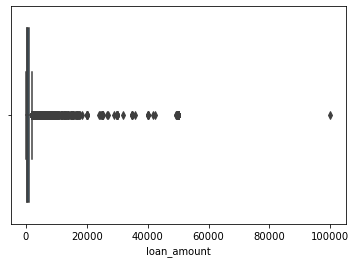

In [9]:
sns.boxplot(x=loans['loan_amount'])

plt.show()

In [10]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

loanamtoutliers = find_outliers_IQR(loans.loan_amount)
loanamtoutliers

35        2225.0
50        3175.0
59        3175.0
62        4275.0
73        2775.0
           ...  
671115    3100.0
671124    2975.0
671126    3725.0
671132    3425.0
671134    3525.0
Name: loan_amount, Length: 50993, dtype: float64

In [38]:
loans_filter = loans.copy()
loans_filter.drop(loans_filter.index[loanamtoutliers.index], inplace=True)

In [39]:
len(loans_filter.index)

620212

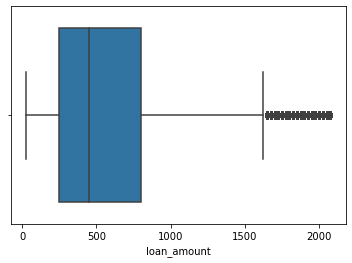

In [40]:
# Outlier removed data
sns.boxplot(x=loans_filter['loan_amount'])
plt.show()

In [41]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='loan_amount', ylabel='Count'>

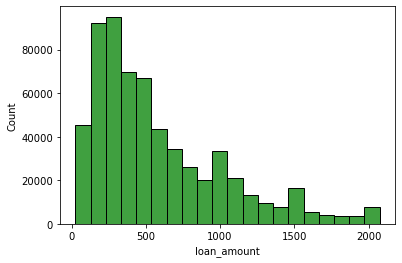

In [42]:
dat = loans_filter['loan_amount']
sns.histplot(data=dat,color='green', bins = 20)

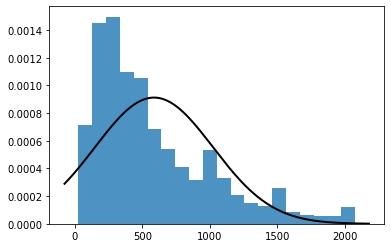

In [43]:
mu, std = norm.fit(dat)
plt.hist(dat, density=True, bins=20, alpha=0.8)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [86]:
from sklearn.preprocessing import StandardScaler
df = pd.DataFrame(loans_filter['loan_amount'].astype('int'))
df.head()

,loan_amount
0,300
1,575
2,150
3,200
4,400


In [89]:
# define standard scaler
scaler = StandardScaler()
  
# transform data
df = scaler.fit_transform(df)
loans_filter['loan_amount_normalized']=df

<AxesSubplot:xlabel='loan_amount_normalized', ylabel='Count'>

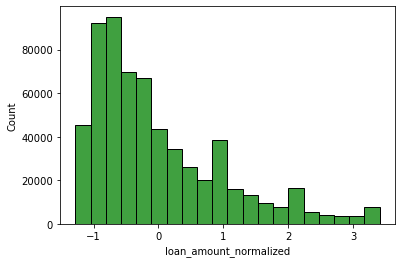

In [94]:
dat = loans_filter['loan_amount_normalized']
sns.histplot(data=dat,color='green', bins = 20)

In [95]:
theme_ids.to_sql('loan_theme_ids', con=engine, if_exists='replace', index=False)

779092

In [96]:
loans_filter.to_sql('loans', con=engine, if_exists='replace', index=False)

620212

In [97]:
mpi_region.to_sql('mpi_region', con=engine, if_exists='replace', index=False)

2772

In [98]:
theme_region.to_sql('theme_region', con=engine, if_exists='replace', index=False)

15736

In [99]:
#Importing country table from world_x from sever and uploading it to kiva table
dfcountry.to_sql('country', con=engine, if_exists='replace', index=False)

239